In [1]:
%load_ext autoreload
%autoreload 2

# Base Notebook to re-create figures of _

This notebook is the base notebook for 10X's Xenium brain showcase tissue sample. It runs the standard ovrlpy pipeline and saves the results to be used in further analysis.

In [2]:
from pathlib import Path

data_folder_path = Path("/dh-projects/ag-ishaque/raw_data/tiesmeys-ovrlpy/Xenium-brain-2024/replicate1")


### Data loader:

In [3]:
import pandas as  pd

coordinate_df = pd.read_parquet(data_folder_path/"transcripts.parquet")
coordinate_df["feature_name"]=coordinate_df.feature_name.str.decode("utf-8")

# remove dummy molecules:
dummy_mask = (coordinate_df.feature_name.str.contains('BLANK') | coordinate_df.feature_name.str.contains('NegControl'))
coordinate_df = coordinate_df[~dummy_mask]

# format columns:
coordinate_df = coordinate_df[['x_location','y_location','z_location','feature_name','cell_id','overlaps_nucleus','qv']]
coordinate_df.columns = ['x','y','z','gene','cell_id','overlaps_nucleus','qv']
coordinate_df['gene'] = coordinate_df['gene'].astype("category")

print(f"Number of cells: {coordinate_df.cell_id.nunique()}",f"Number of genes: {coordinate_df.gene.nunique()}",f"Number of molecules: {coordinate_df.shape[0]}",sep="\n")

Number of cells: 162034
Number of genes: 248
Number of molecules: 62384369


### Run the basic ovrlppy pipeline:

We expect a roughly estimated 30 cell types in the sample. For the remaining parameters, we use the default values.

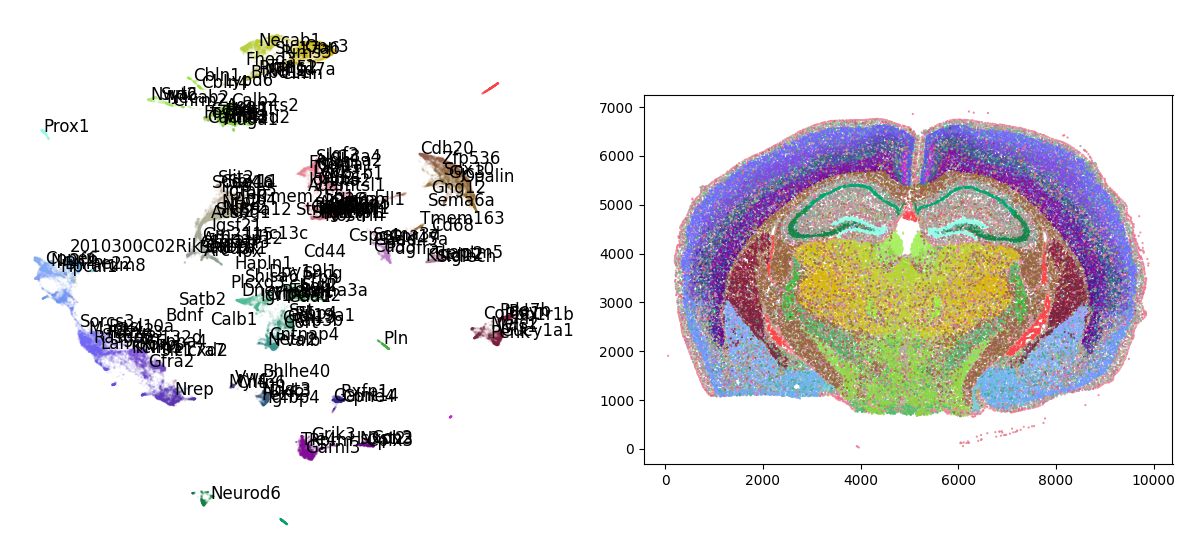

In [4]:
import ovrlpy

visualizer = ovrlpy.load_visualizer('./publication/xenium-brain/xenium-brain.vis')

signal_integrity,signal_strength = visualizer.integrity_map,visualizer.signal_map

visualizer.plot_fit()

### UMAP annotation using external gene expression signatures:

We can use external gene expression signatures to annotate the UMAP. In this case, we use cell features extracted from the allen brain atlas (REF):

In [5]:
# import numpy as np
# import matplotlib.pyplot as plt

# signatures_ = pd.read_csv('/dh-projects/ag-ishaque/raw_data/Xenium-benchmark/scRNAseq/trimmed_means.csv',index_col=0)

# signatures_ = signatures_.T.groupby(lambda x: x.split('_')[1].split(' ')[0].split('-')[0]).apply(lambda x: x.mean(0)).T

# signatures = pd.DataFrame(index=visualizer.genes,columns=signatures_.columns)
# signatures = signatures.fillna(0.0)

# for gene in visualizer.genes:
#     if gene in signatures_.index:
#         signatures.loc[gene] = signatures_.loc[gene]

# del signatures_ 

# signatures.columns=signatures.columns.str.replace('/','-')

# visualizer.fit_signatures(signatures)

# visualizer.plot_fit()

# # plt.savefig("./manuscript/figures/results/xenium-brain/ct_fit.svg")

#### Load the official metadata, incuding cell type assignments;  

In [6]:
import anndata as ad

adata = ad.read_mtx(data_folder_path/"cell_feature_matrix/matrix.mtx").T
adata.var = pd.read_csv(data_folder_path/"cell_feature_matrix/features.tsv", header=None, index_col=1, names=["gene_id", "gene", "feature_type"],sep="\t")
obs_dict = pd.read_parquet(data_folder_path/"cells.parquet",)#.set_index("cell_id")
for c in obs_dict.columns:
    adata.obs[c] = obs_dict[c].values
adata.obs.set_index("cell_id",inplace=True)
adata.obs.index = adata.obs.index.astype("category")
adata.obs[['x_centroid','y_centroid']]

# Filter out empty cells:
# adata = adata[adata.X.sum(axis=1)>50]

x_centroid   y_centroid
cell_id                          
1        1557.532239  2528.022437
2        1560.669312  2543.632678
3        1570.462885  2530.810461
4        1573.927734  2546.454529
5        1581.344379  2557.024951
...              ...          ...
162029   8310.558740  4345.094580
162030   8316.195801  4321.954077
162031   8323.133594  4271.474121
162032   8327.415137  4348.097388
162033   8326.575928  4248.579736

[162033 rows x 2 columns]

#### Load the official segmentation mask & create a pixel map of cells

In [ ]:
# !pip install shapely rasterio
from shapely.geometry import Polygon as shapely_Polygon
import tqdm
import rasterio
from rasterio.features import rasterize
import numpy as np

um_per_pixel=1

cell_boundaries = pd.read_parquet(data_folder_path/"cell_boundaries.parquet")
nucleus_boundaries = pd.read_parquet(data_folder_path/"nucleus_boundaries.parquet")
cell_boundaries[['vertex_x','vertex_y']]/=um_per_pixel
nucleus_boundaries[['vertex_x','vertex_y']]/=um_per_pixel

polygons_nucleus = []
polygons_cell = []
 
for i, cell_id in tqdm.tqdm(enumerate(adata.obs.index),total = len(adata.obs)):
    coords_nucleus = nucleus_boundaries[nucleus_boundaries.cell_id==cell_id][['vertex_x','vertex_y']]     
    polygons_nucleus.append((shapely_Polygon(coords_nucleus.values),cell_id))
    
    coords_cell = cell_boundaries[cell_boundaries.cell_id==cell_id][['vertex_x','vertex_y']]
    polygons_cell.append((shapely_Polygon(coords_cell.values),cell_id))
    
segmentation_map_ = rasterize(polygons_nucleus, out_shape=signal_strength.shape, fill=np.nan, all_touched=True, dtype=float, )


In [9]:
cell_boundaries

cell_id     vertex_x     vertex_y
0              1  1554.650024  2519.187500
1              1  1550.824951  2521.524902
2              1  1549.550049  2523.437500
3              1  1550.187500  2526.625000
4              1  1551.037476  2537.887451
...          ...          ...          ...
2106374   162033  8332.125000  4247.024902
2106375   162033  8333.400391  4242.137695
2106376   162033  8333.825195  4238.737305
2106377   162033  8329.362305  4236.825195
2106378   162033  8329.150391  4236.825195

[2106379 rows x 3 columns]

#### Sample the signal integrity at the given cell segments:

/tmp/ipykernel_2955955/3612257859.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  adata.obs["above_threshold"] = signal_integrity_integration_groups.apply(lambda x: np.mean(x.signal_integrity_>0.3))


x_centroid   y_centroid  transcript_counts  control_probe_counts  \
cell_id                                                                      
1        1557.532239  2528.022437                327                     0   
2        1560.669312  2543.632678                354                     0   
3        1570.462885  2530.810461                422                     0   
4        1573.927734  2546.454529                250                     0   
5        1581.344379  2557.024951                550                     1   
...              ...          ...                ...                   ...   
162029   8310.558740  4345.094580                555                     0   
162030   8316.195801  4321.954077                266                     0   
162031   8323.133594  4271.474121                488                     0   
162032   8327.415137  4348.097388                176                     0   
162033   8326.575928  4248.579736                328                     0   

         control_codeword_counts  total_counts   cell_area  nucleus_area  \
cell_id                                                                    
1                              0           327  240.953750     63.038125   
2                              0           354  211.692500     65.476562   
3                              0           422  186.946875     69.540625   
4                              0           250  239.237813     61.728594   
5                              0           552  438.692969     92.209063   
...                          ...           ...         ...           ...   
162029                         0           557  515.955312     76.991406   
162030                         0           266  268.002344     13.637188   
162031                         1           489  346.483906     77.036563   
162032                         0           176  169.922969      9.889219   
162033                         0           328  210.066875     18.920469   

         mean_purity  min_purity  median_purity  quartile_purity  \
cell_id                                                            
1           0.724163    0.581793       0.717699         0.771254   
2           0.775833    0.516476       0.784409         0.855968   
3           0.775190    0.580179       0.791891         0.827913   
4           0.768660    0.499832       0.769635         0.881376   
5           0.697949    0.490359       0.705238         0.771391   
...              ...         ...            ...              ...   
162029      0.739043    0.561227       0.747911         0.786128   
162030      0.790464    0.691815       0.797457         0.828896   
162031      0.662223    0.342998       0.685716         0.751562   
162032      0.642017    0.511404       0.653211         0.694396   
162033      0.713497    0.435262       0.752012         0.808779   

         above_threshold   area assignments_by_marker_counts  marker_purities  \
cell_id                                                                         
1                    1.0   75.0                      Neurons         0.693878   
2                    1.0   80.0                      Neurons         0.765396   
3                    1.0   87.0                      Neurons         0.688776   
4                    1.0   54.0                      Neurons         0.480851   
5                    1.0  108.0                      Neurons         0.679359   
...                  ...    ...                          ...              ...   
162029               1.0   94.0                      Neurons         0.700210   
162030               1.0   20.0                      Neurons         0.720721   
162031               1.0   96.0                      Neurons         0.733634   
162032               1.0   17.0                      Neurons         0.600000   
162033               1.0   26.0                      Neurons         0.761745   

         mapmycells_corrcoef  mmc_family        mmc_class  mean_sig

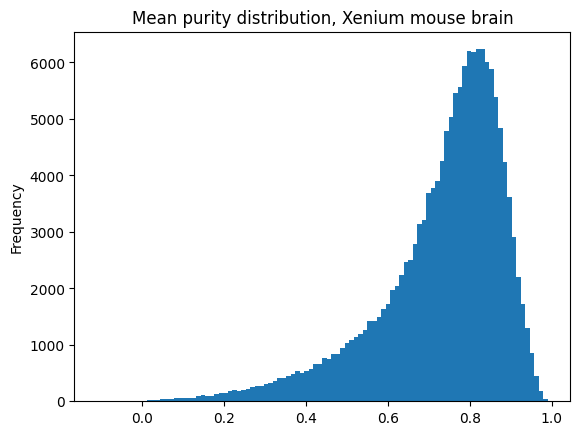

In [57]:

signal_integrity_ = signal_integrity.copy()
signal_integrity_[signal_strength<1]=np.nan

signal_integrity_integration_mask = (signal_strength>1.5) & (segmentation_map_>0)

signal_integrity_integration_df = pd.DataFrame(signal_integrity_[signal_integrity_integration_mask].flatten(),columns=['signal_integrity_'])
signal_integrity_integration_df['segmentation_map'] = segmentation_map_[signal_integrity_integration_mask].flatten()
signal_integrity_integration_df['signal_strength'] = signal_strength[signal_integrity_integration_mask].flatten()

signal_integrity_integration_groups = signal_integrity_integration_df.groupby('segmentation_map')


adata.obs["mean_purity"] = signal_integrity_integration_groups.mean().signal_integrity_
adata.obs["min_purity"] = signal_integrity_integration_groups.min().signal_integrity_
adata.obs["median_purity"] = signal_integrity_integration_groups.median().signal_integrity_
adata.obs["quartile_purity"] = signal_integrity_integration_groups.quantile(0.75).signal_integrity_
adata.obs["above_threshold"] = signal_integrity_integration_groups.apply(lambda x: np.mean(x.signal_integrity_>0.3))
adata.obs["area"] = signal_integrity_integration_groups.size()
adata.obs["mean_signal"] = signal_integrity_integration_groups.mean().signal_strength

adata.obs.mean_purity.plot.hist(bins=100, title="Mean purity distribution, Xenium mouse brain")

adata.obs



/tmp/ipykernel_2955955/4106872359.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_marker_counts = gene_group_df.groupby("group").apply(lambda x: np.array(adata.X[:,x.idx].sum(1)).flatten())


<Axes: ylabel='Frequency'>

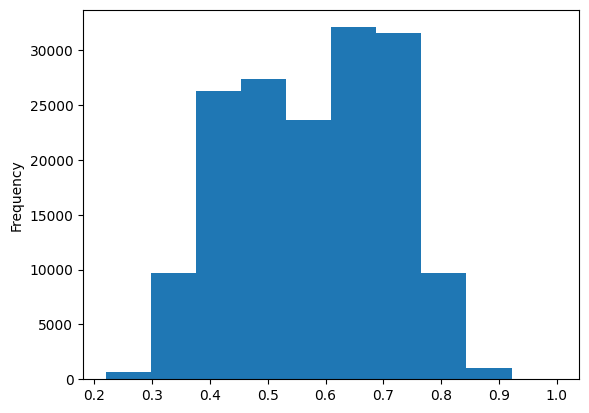

In [58]:
import numpy as np

gene_group_df = pd.read_csv(data_folder_path/"Xenium_V1_FF_Mouse_Brain_MultiSection_Input_gene_groups.csv",header=0,index_col=0,usecols=[0,1])
gene_group_df['idx']=np.arange(len(gene_group_df))

group_marker_counts = gene_group_df.groupby("group").apply(lambda x: np.array(adata.X[:,x.idx].sum(1)).flatten())
group_marker_counts = pd.DataFrame(group_marker_counts.values.tolist(),index=group_marker_counts.index,columns=adata.obs.index)

assignments_by_marker_counts = group_marker_counts.idxmax(axis=0)
marker_purities = np.array([group_marker_counts.at[idx, col] for idx, col in zip(assignments_by_marker_counts.values, assignments_by_marker_counts.index)])/group_marker_counts.sum(0)

marker_purities

adata.obs["assignments_by_marker_counts"] = assignments_by_marker_counts
adata.obs["marker_purities"] = marker_purities

adata.obs.marker_purities.plot.hist()

#### Create count matrix for use in mapmycells:

/tmp/ipykernel_2955955/2165753408.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_df = coordinate_df.groupby("gene").apply(lambda x:x.cell_id.value_counts())
/tmp/ipykernel_2955955/2165753408.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  counts_df = coordinate_df.groupby("gene").apply(lambda x:x.cell_id.value_counts())
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

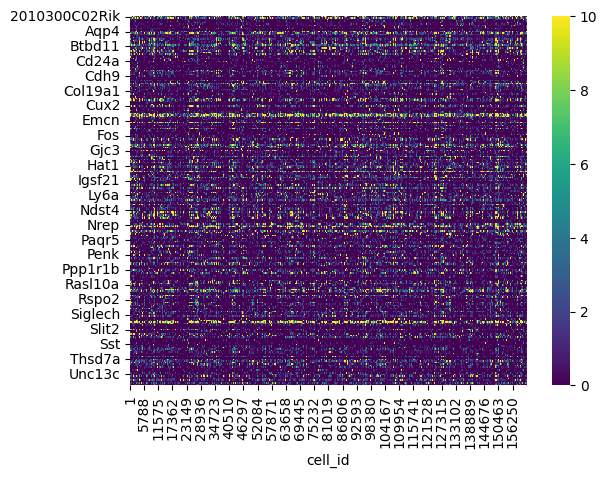

: 

In [36]:
# !pip install seaborn
import seaborn as sns

count_mtx = pd.DataFrame(index=coordinate_df.gene.cat.categories,columns=adata.obs.index,dtype=int).fillna(0)
counts_df = coordinate_df.groupby("gene").apply(lambda x:x.cell_id.value_counts())


for i,g in tqdm.tqdm(enumerate(coordinate_df.gene.cat.categories),total=len(coordinate_df.gene.cat.categories)):
    count_mtx.loc[g] = counts_df[g]
    
count_mtx.fillna(0,inplace=True)
    
sns.heatmap(count_mtx,cmap='viridis',vmax=10)

import anndata
anndata.AnnData(count_mtx.T).write_h5ad("./publication/xenium-brain/segments/mapmycells/count_mtx_nuclei.h5ad")


In [59]:
import os


def load_mapmycells_csv(region=''):
    files = os.listdir(f"publication/xenium-brain/segments/mapmycells/{region}/")
    csv = sorted([f for f in files if f.endswith(".csv")])[-1]
    
    mapmycells_df = pd.read_csv(f"publication/xenium-brain/segments/mapmycells/{region}/{csv}",index_col=0,skiprows=4)
    
    return mapmycells_df


### Create a publishable HD figure of the colorized tissue:

#### Upload mapmycells cell type assignments:

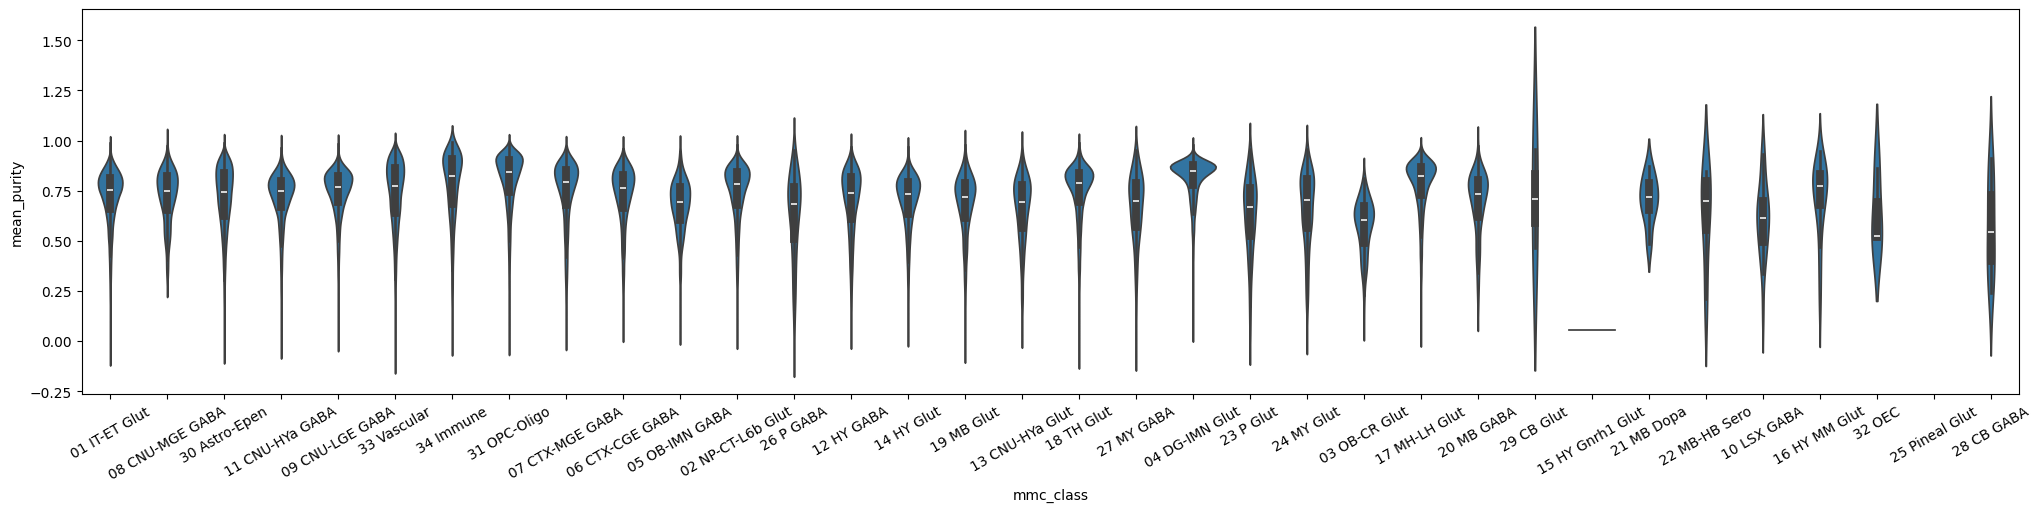

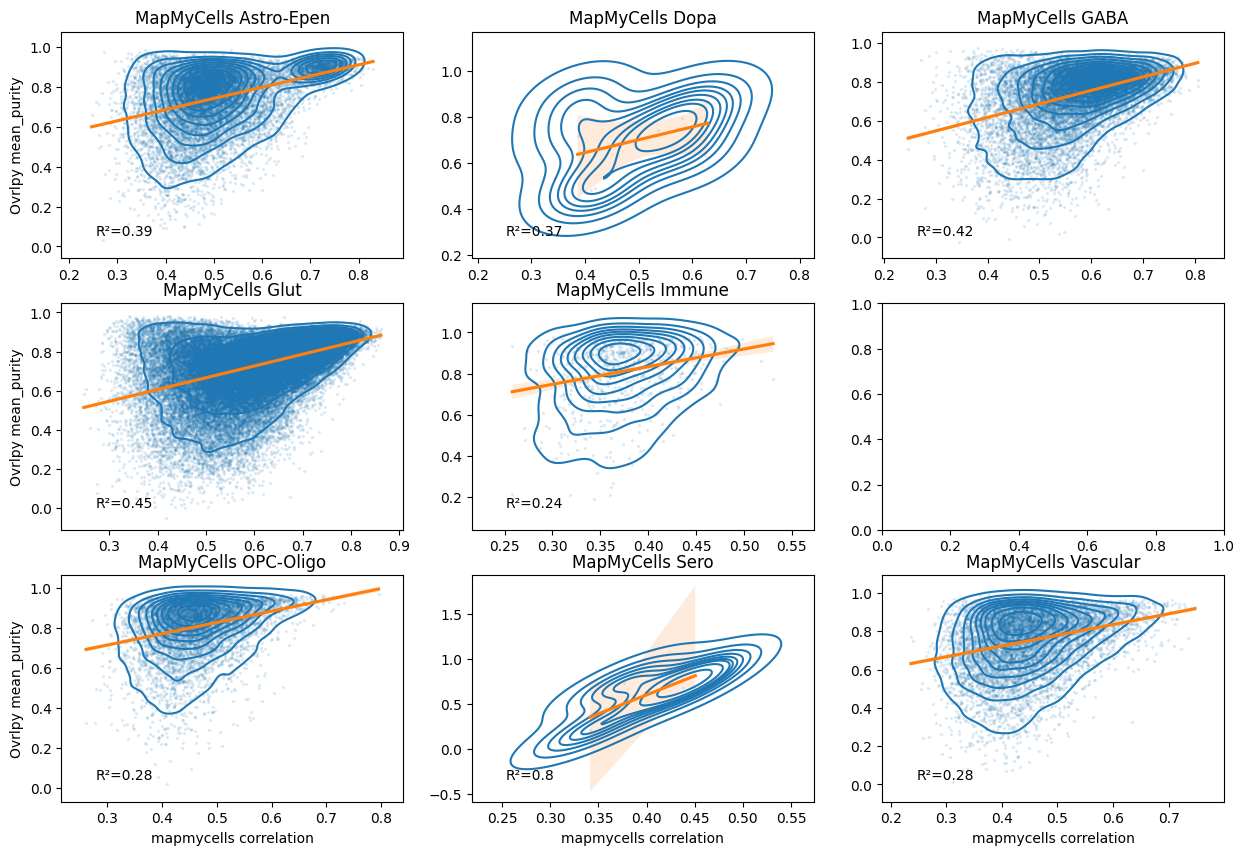

In [60]:
# # mapmycells assignments:

import matplotlib.pyplot as plt
# import seaborn as sns
from scipy import stats

mapmycells_df = load_mapmycells_csv()
# # mapmycells_df

adata.obs["mapmycells_corrcoef"] = mapmycells_df.class_correlation_coefficient

measure = "mean_purity"


# # data_mask = ((~adata.obs[measure].isna())&np.array(adata.X.sum(1)>0).flatten()&(adata.obs["area"]>0))


mapmycells_df['family_name'] = mapmycells_df.class_name.str.split(' ').str[-1].astype('category')

adata.obs['mmc_family'] = mapmycells_df['family_name']
adata.obs['mmc_class'] = mapmycells_df['class_name']

fig, ax = plt.subplots(figsize=(25,5))
sns.violinplot(data=adata.obs,x='mmc_class',y=measure,ax=ax)
plt.xticks(rotation=30)

''
fig = plt.figure(figsize=(15,10))

for i,cls in enumerate(mapmycells_df.family_name.cat.categories):

    
    ax = plt.subplot(3,3,i+1)


    data_mask = ((mapmycells_df.family_name==cls)&np.array(adata.X.sum(1)>150).flatten()&(adata.obs["area"]>10))

    if sum(data_mask)<3:
        continue

    sns.kdeplot(adata.obs[data_mask],x='mapmycells_corrcoef',y=measure,ax=ax,)
    pearson,p = stats.pearsonr(adata.obs[data_mask]['mapmycells_corrcoef'],adata.obs[data_mask][measure])
    pearson = round(pearson,2)


    sns.regplot(adata.obs[data_mask],x='mapmycells_corrcoef',y=measure,
                fit_reg=True,scatter_kws={'alpha':0.1,'color':None, 
                                            # 'c':np.array(-adata.obs[data_mask].area).flatten(),
                                            # 'c':[data_mask],
                                            'cmap':None,'vmin':None,'vmax':None,'s':2},ax=ax).text(0.1, 0.1, f"R²={pearson}",  transform=ax.transAxes)
        
        
    plt.title(f"MapMyCells {cls}")
    
    if i>5:
        ax.set_xlabel('mapmycells correlation')
    else:
        ax.set_xlabel('')
        
    if (i%3):
        ax.set_ylabel('')
    else:
        ax.set_ylabel('Ovrlpy '+measure)
        
# # # plt.colorbar()


/dh-projects/ag-ishaque/analysis/tiesmeys/src/ovrlpy_24/conda-ovrlpy/lib/python3.12/site-packages/seaborn/regression.py:411: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, **kws)
/dh-projects/ag-ishaque/analysis/tiesmeys/src/ovrlpy_24/conda-ovrlpy/lib/python3.12/site-packages/seaborn/regression.py:411: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, **kws)
/dh-projects/ag-ishaque/analysis/tiesmeys/src/ovrlpy_24/conda-ovrlpy/lib/python3.12/site-packages/seaborn/regression.py:411: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, **kws)
/dh-projects/ag-ishaque/analysis/tiesmeys/src/ovrlpy_24/conda-ovrlpy/lib/python3.12/site-packages/seaborn/regression.py:411: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, **kws)
/dh-projects/ag-ishaque/analysis/tie

Text(-0.01, 0.5, 'ovrlpy purity')

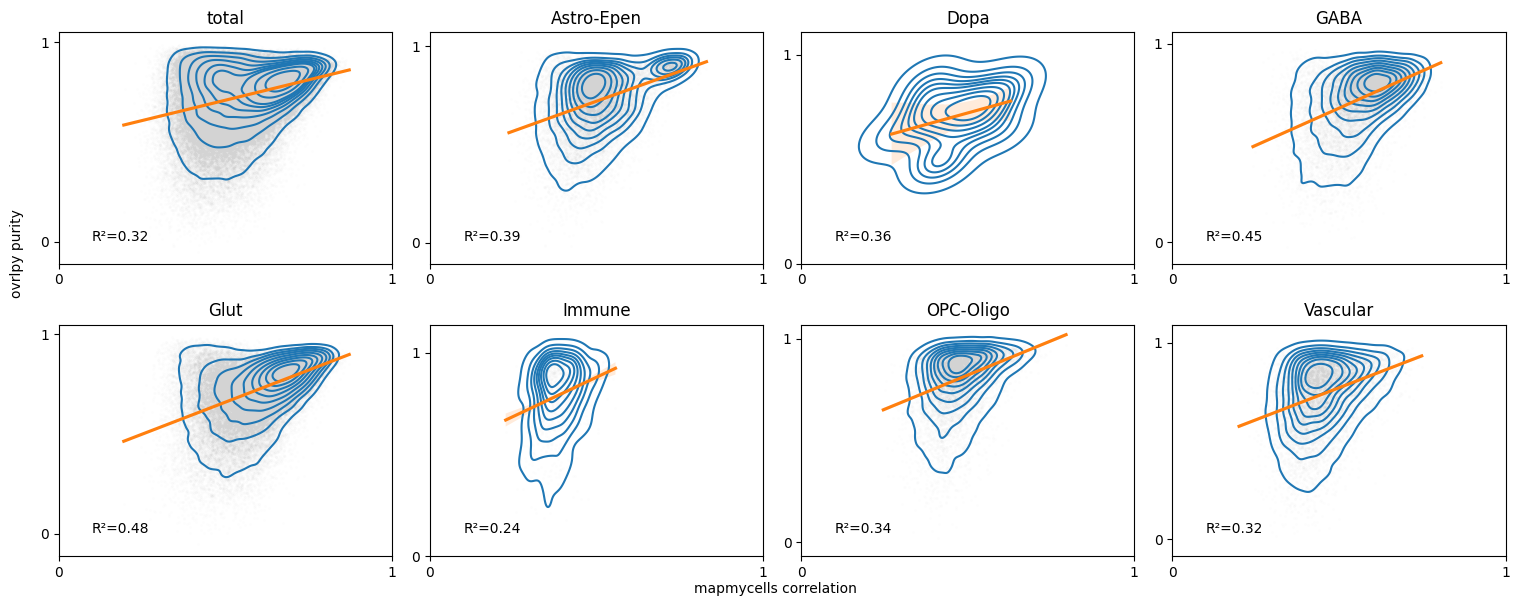

In [61]:
from scipy import stats

data_mask = (np.array(adata.X.sum(1)>50).flatten()&(adata.obs["area"]>10))

fig = plt.figure(figsize=(15,6))

    
pearson,p = stats.pearsonr(adata.obs[data_mask]['mapmycells_corrcoef'].fillna(0),adata.obs[data_mask][measure].fillna(0))
pearson = round(pearson,2)
    
ax=plt.subplot(2,4,1)

sns.kdeplot(adata.obs[data_mask],x='mapmycells_corrcoef',y='mean_purity',ax=ax,)
sns.regplot(adata.obs[data_mask],x='mapmycells_corrcoef',y='mean_purity',
            fit_reg=True,scatter_kws={'alpha':0.01,'color':None, 
                                        'c': 'lightgrey',#-(mapmycells_df_top.class_label == mapmycells_df_bottom.class_label)[data_mask],
                                        # 'c':[data_mask],
                                        'cmap':'bwr','vmin':None,'vmax':None,'s':2},ax=ax).text(0.1, 0.1, f"R²={pearson}",  transform=ax.transAxes)

plt.xlabel("")
plt.ylabel("")
plt.xticks([0,1])
plt.yticks([0,1])

plt.title('total')

celltypes = [c for c in sorted(mapmycells_df.family_name.unique()) if not c in ('OEC', 'Sero') ]

for i,celltype in enumerate(celltypes):
    
    ax = plt.subplot(2,4,i+2)
    
    data_mask = (np.array(adata.X.sum(1)>50).flatten()&(adata.obs["area"]>10))&(mapmycells_df.family_name==celltype)
    
    if sum(data_mask)<3:
        pearson,p='nan','nan'
        
    else:  
        pearson,p = stats.pearsonr(adata.obs[data_mask]['mapmycells_corrcoef'].fillna(0),adata.obs[data_mask][measure].fillna(0))
        pearson = round(pearson,2)
    
    
    sns.kdeplot(adata.obs[data_mask],x='mapmycells_corrcoef',y='mean_purity',ax=ax,)
    sns.regplot(adata.obs[data_mask],x='mapmycells_corrcoef',y='mean_purity',
                fit_reg=True,scatter_kws={'alpha':0.01,'color':None, 
                                            'c': 'lightgrey',#-(mapmycells_df_top.class_label == mapmycells_df_bottom.class_label)[data_mask],
                                            # 'c':[data_mask],
                                            'cmap':'bwr','vmin':None,'vmax':None,'s':2}).text(0.1, 0.1, f"R²={pearson}",  transform=ax.transAxes)
    
    plt.title(celltype)

    plt.xlabel("")
    plt.ylabel("")
    plt.xticks([0,1])
    plt.yticks([0,1])
    
plt.tight_layout()
    

fig.text(0.5, 0.01, 'mapmycells correlation', va='center', ha='center')
fig.text(-0.01, 0.5,'ovrlpy purity', rotation='vertical')

# plt.legend([plt.Circle((0,0),1,color='b'),plt.Circle((0,0),1,color='r')],['singlet','doublet'],loc='lower right')

In [94]:
adata.obs.iloc[int(ovrlpy_pure_xenium_impure.index[0])-1][['x_centroid','y_centroid']]



x_centroid    6175.839355
y_centroid    3031.036084
Name: 90421, dtype: object

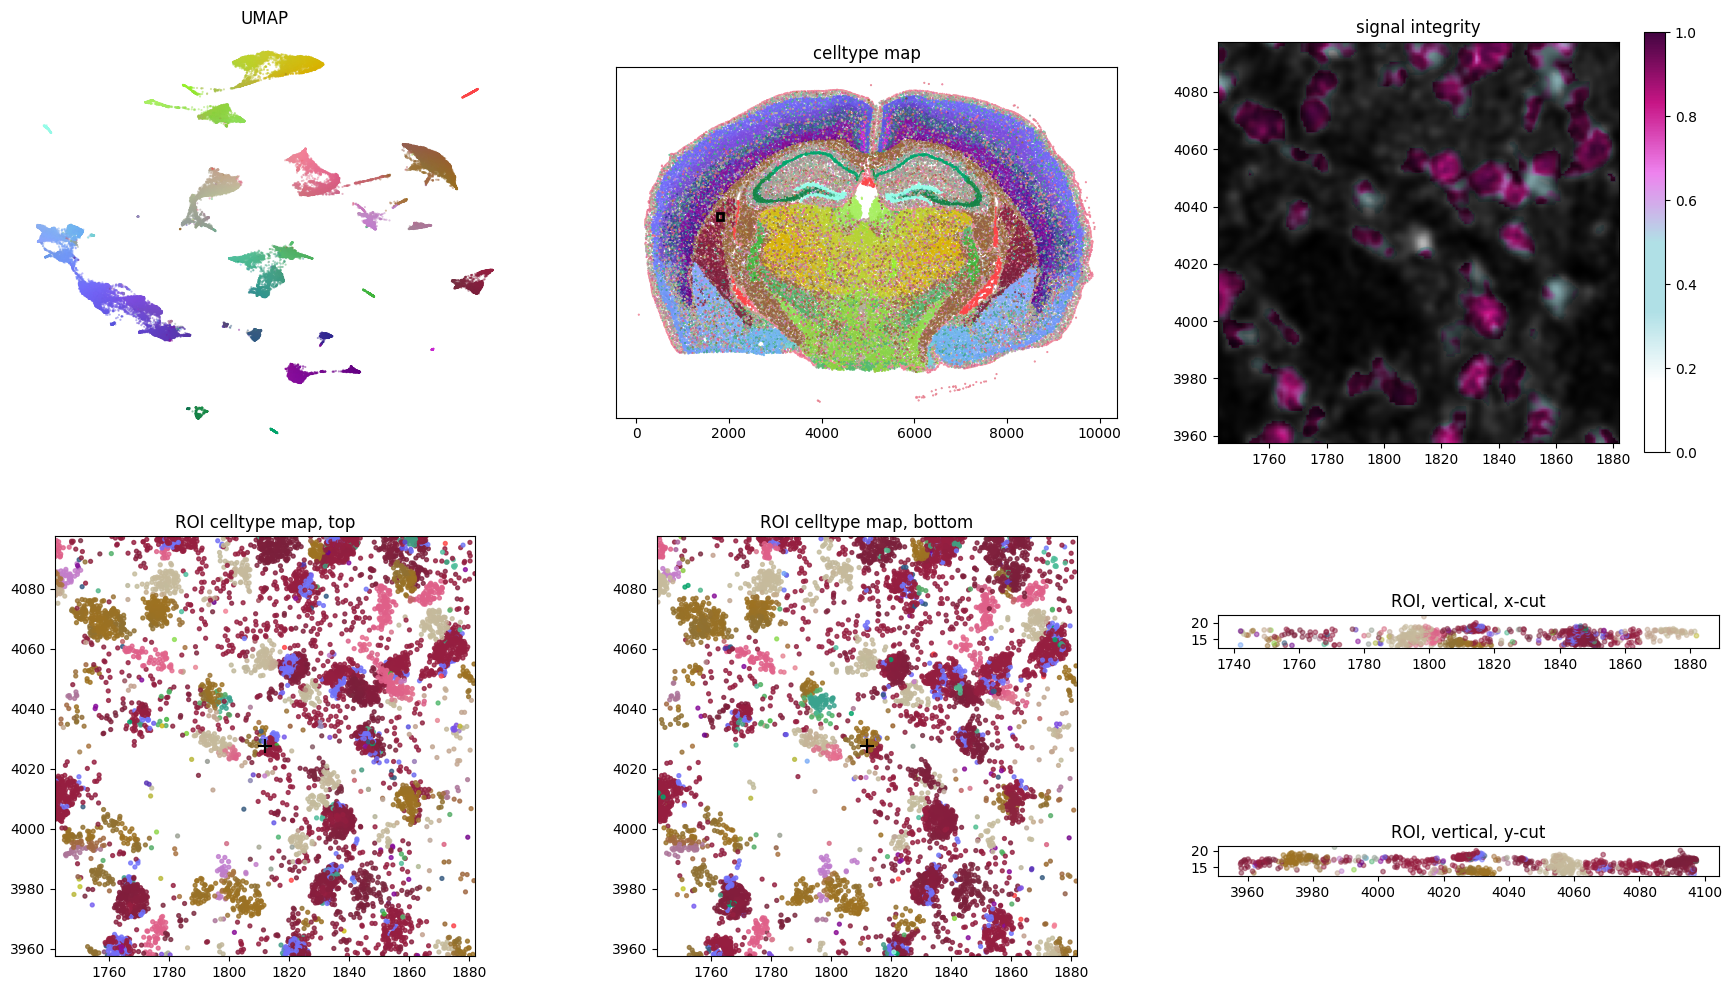

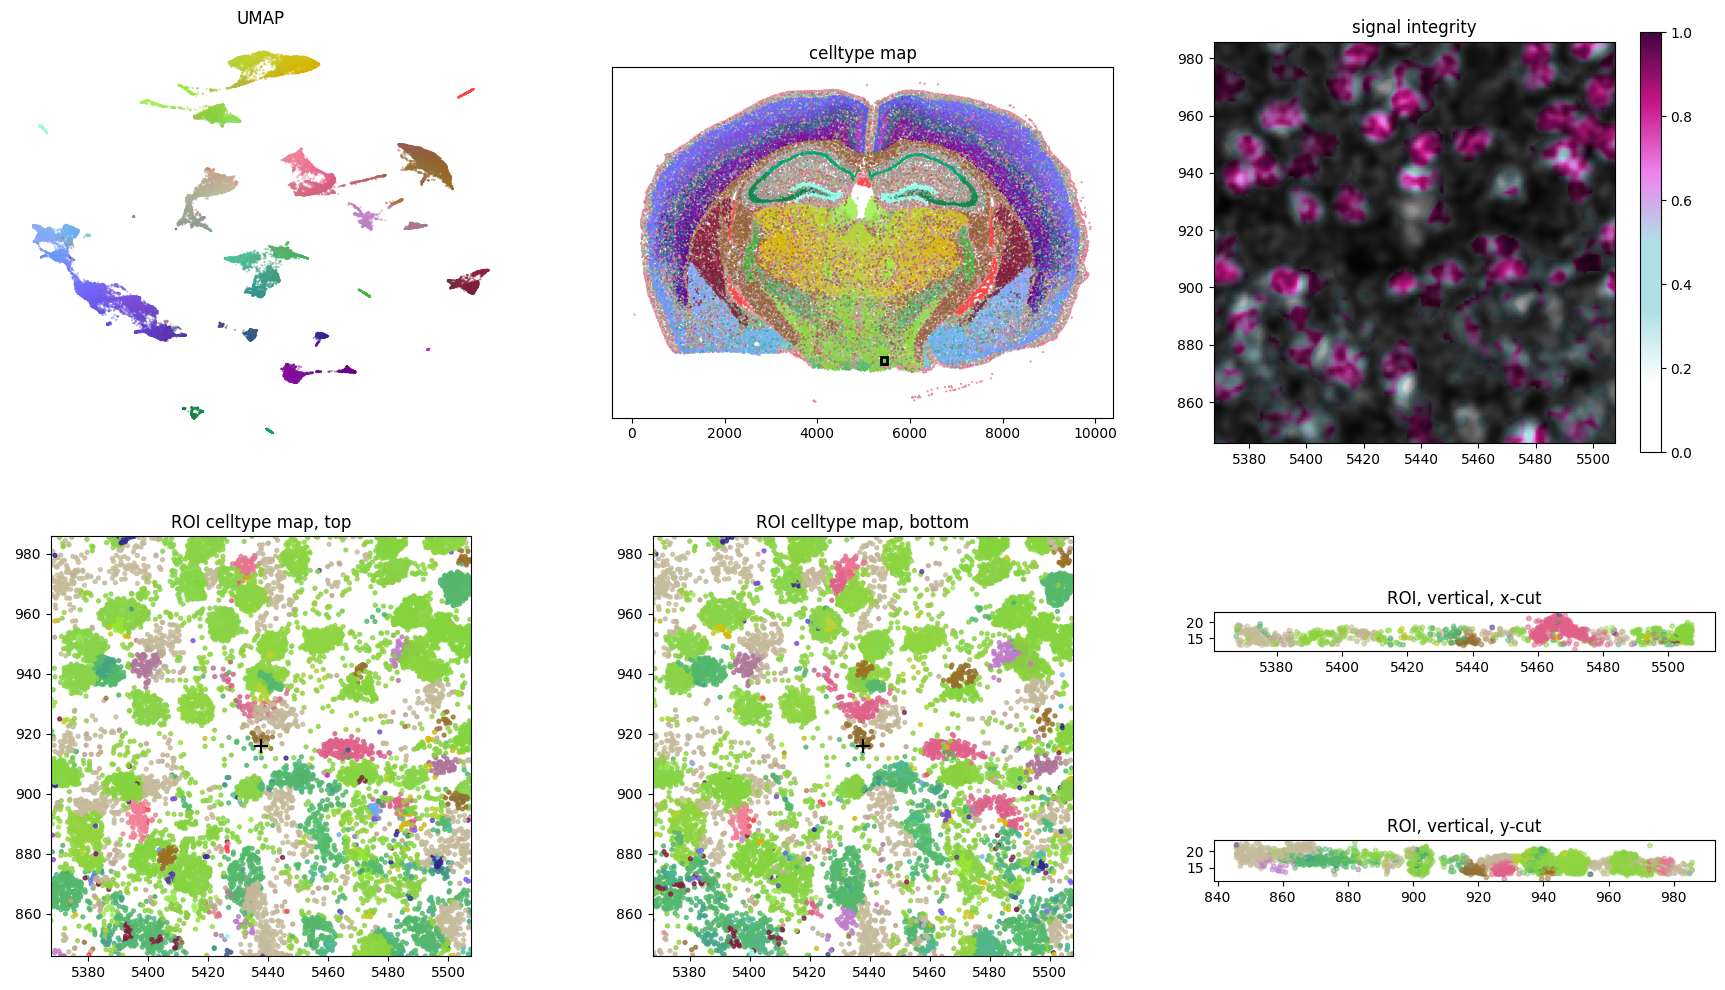

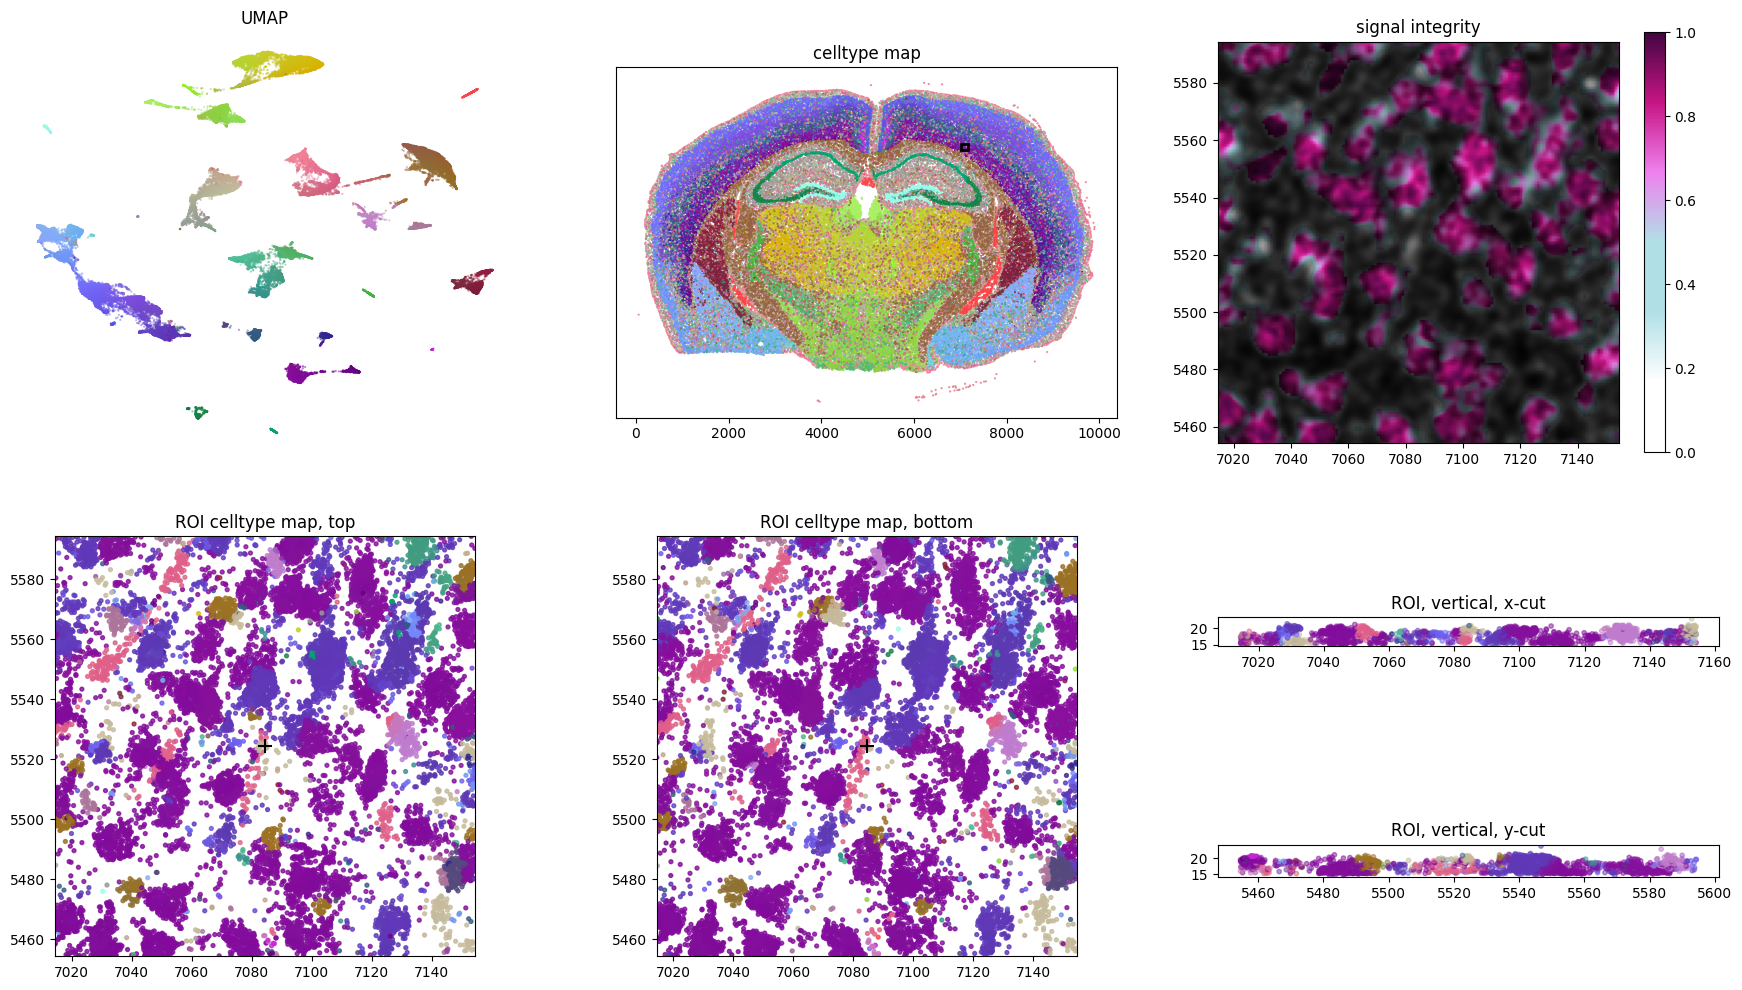

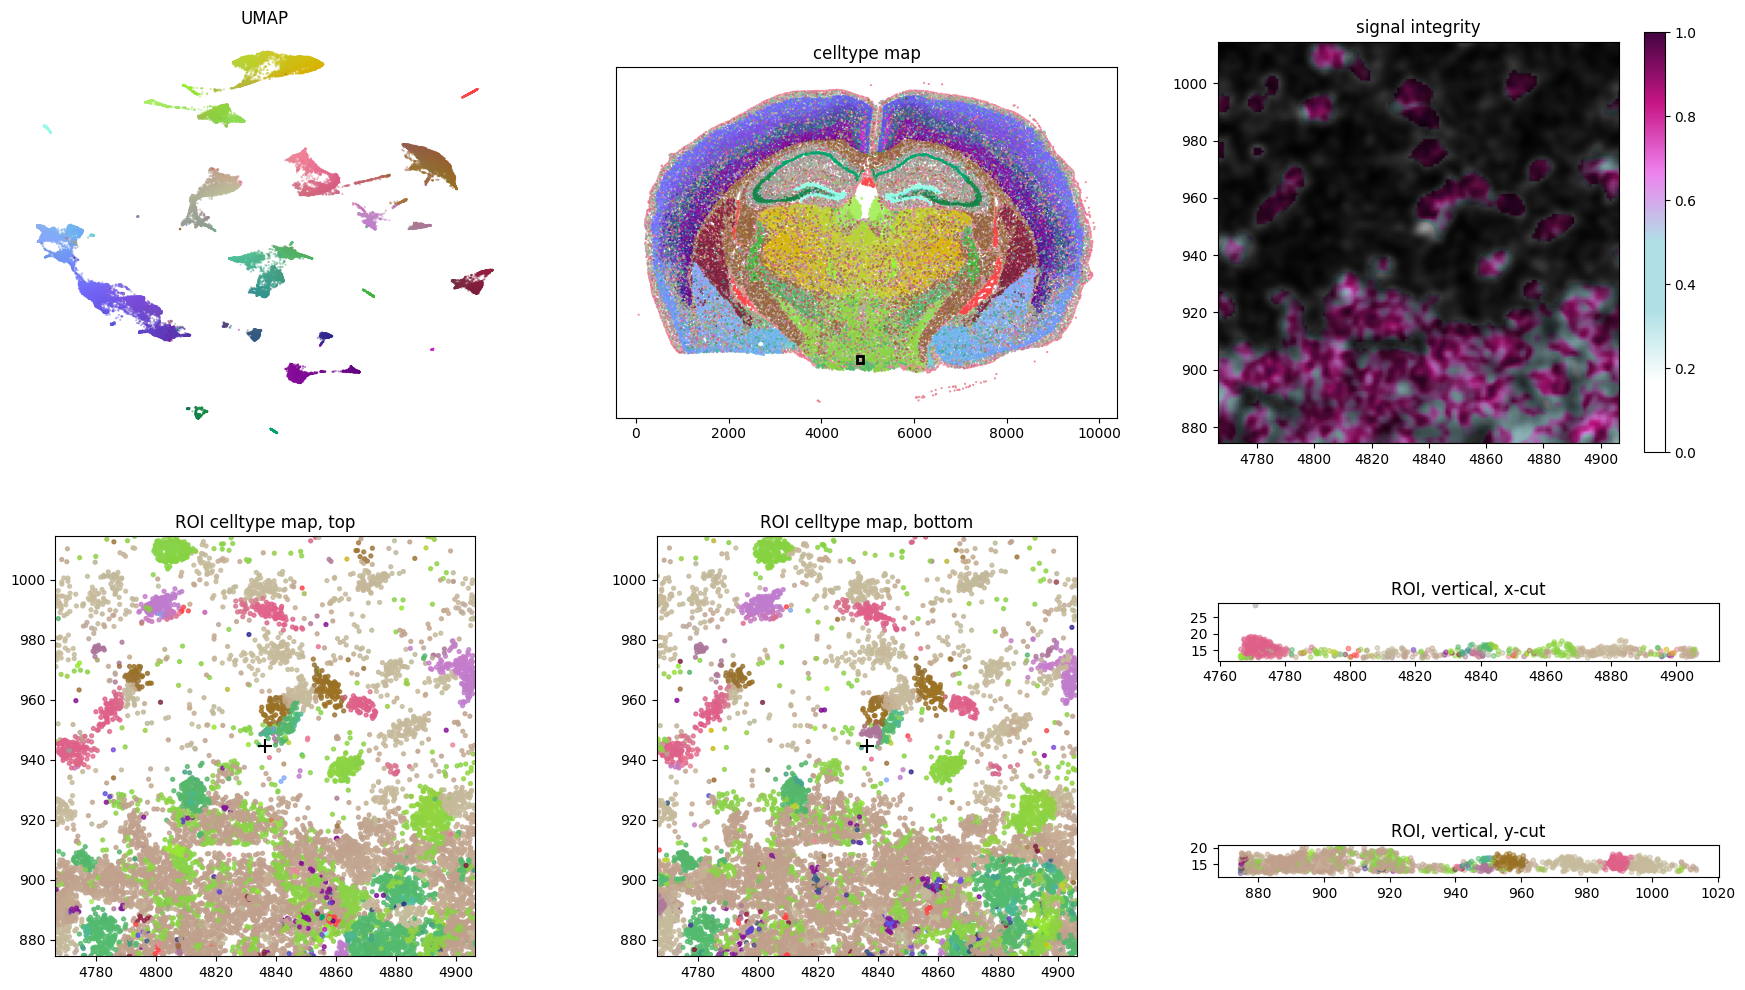

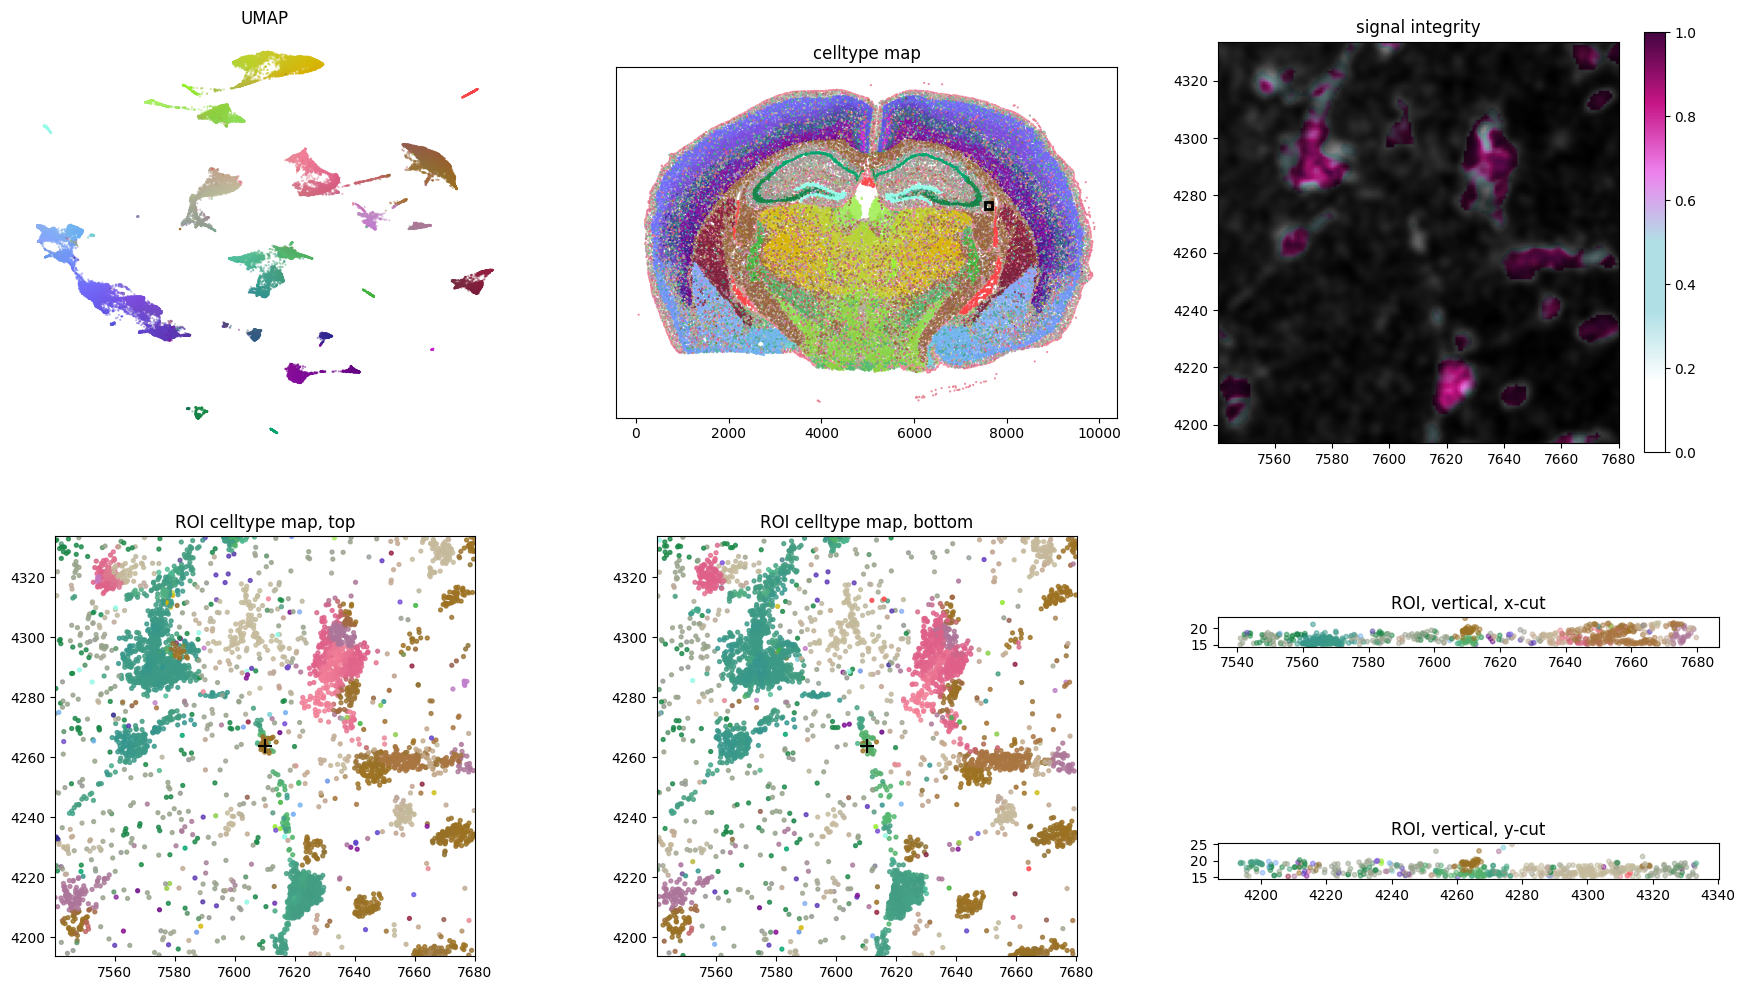

In [97]:
# Drawing out the four regions of interest:

import matplotlib.patches as patches
import random
from matplotlib.colors import LinearSegmentedColormap

# cmap = LinearSegmentedColormap.from_list('rolands_pride', ['#430541','mediumvioletred','violet','powderblue','white','white'][::-1])
# mapmycells_top_bottom_match = (mapmycells_df_top.family_name == mapmycells_df_bottom.family_name)

# def plot_cells(cells_present,ax):
#     nucleus_boundaries[nucleus_boundaries.cell_id.isin(cells_present)]

#     for i,c in enumerate(cells_present):
        
#         boundary_subset = nucleus_boundaries[nucleus_boundaries.cell_id==c]
        
#         if c in adata.obs.index:
                
#             color = 'c' if mapmycells_top_bottom_match[c] else 'r'
            
#             plt.plot(boundary_subset.vertex_x,boundary_subset.vertex_y,c=color,linewidth=1)
            
#             # mean_purity = adata.obs[adata.obs.index==c].mean_purity.iloc[0]
#             mean_purity = adata.obs[adata.obs.index==c].above_threshold.iloc[0]

#             if not np.isnan(mean_purity):

#                 text = plt.text(boundary_subset.vertex_x.mean(),boundary_subset.vertex_y.mean(),f".{int(mean_purity*10)}",fontsize=12,ha='center',color=color)
#                 plt.gca().add_artist(text)


data_mask = (np.array(adata.X.sum(1)>50).flatten()&(adata.obs["area"]>10))
# ovrlpy_impure_xenium_impure = ((1/adata.obs.mean_purity/adata.obs.mapmycells_corrcoef)[data_mask]).sort_values()
# ovrlpy_pure_xenium_impure = ((adata.obs.mean_purity-adata.obs.mapmycells_corrcoef)[data_mask]).sort_values()
ovrlpy_impure_xenium_pure = ((1/adata.obs.mean_purity*adata.obs.mapmycells_corrcoef)[data_mask]).sort_values()
# ovrlpy_pure_xenium_pure = ((adata.obs.mean_purity*adata.obs.mapmycells_corrcoef)[data_mask]).sort_values()

# adata.obs[(adata.obs.mean_purity<0.3)&(adata.obs.mapmycells_corrcoef<0.3)]
# ovrlpy_pure_xenium_impure = adata.obs[(adata.obs.mean_purity>0.8)&(adata.obs.mapmycells_corrcoef<0.3)]
# ovrlpy_impure_xenium_pure = adata.obs[(adata.obs.mean_purity<0.3)&(adata.obs.mapmycells_corrcoef>0.5)]
# ovrlpy_pure_xenium_pure = adata.obs[(adata.obs.mean_purity>0.8)&(adata.obs.mapmycells_corrcoef>0.5)]
            
window_size = 70

for i in range(5):
    
    x,y = adata.obs.iloc[int(ovrlpy_impure_xenium_pure.index[i])-1][['x_centroid','y_centroid']]

    
    ovrlpy.plot_region_of_interest(
        x,
        y,
        coordinate_df,
        visualizer,
        signal_integrity,
        signal_strength,
        window_size=window_size,
    )
    
    